sudo PYTHONPATH=$PYTHONPATH:$PWD/CARLA_0.9.6/PythonAPI/carla/dist/carla-0.9.6-py3.5-linux-x86_64.egg ./../anaconda3/envs/c557/bin/jupyter notebook --allow-root


In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import time
import cv2

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
import os
images = os.listdir("images/images")

FileNotFoundError: [Errno 2] No such file or directory: 'images/images'

In [17]:
tf.config.list_physical_devices("GPU")

[]

In [ ]:
latent_dim = 1024

In [18]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [19]:
encoder_inputs = keras.Input(shape=(128, 128, 1))
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(8, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(latent_dim, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)

z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 16)   160         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 8)    1160        conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 8192)         0           conv2d_3[0][0]                   
____________________________________________________________________________________________

In [20]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8192, activation="relu")(latent_inputs)
x = layers.Reshape((32, 32, 8))(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense_3 (Dense)              (None, 8192)              8396800   
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 64, 64, 16)        1168      
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 128, 128, 16)      2320      
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 128, 128, 1)       145       
Total params: 8,400,433
Trainable params: 8,400,433
Non-trainable params: 0
_________________________________________________

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [9]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [10]:
def read_transform(path):
    img = cv2.imread(path)/255
    #img = 0.6*(img[76:204,76:204,0]) + 0.4*img[76:204,76:204,2] #RGB
    img = 0.6*(img[:,:,0]) + 0.4*img[:,:,2]
    return img.reshape((128,128,1))

train_batch = np.zeros( (len(images), 128, 128, 1) )
for i, img in enumerate(images):
    train_batch[i] = read_transform(f'../images/images/{img}')
train_batch.shape

(4684, 128, 128, 1)

In [11]:
history = vae.fit(train_batch, epochs=25, batch_size=128)

Epoch 1/25
37/37 [==============================] - 21s 534ms/step - loss: 10604.4561 - reconstruction_loss: 9808.4443 - kl_loss: 48.4348
Epoch 2/25
37/37 [==============================] - 20s 548ms/step - loss: 8889.1137 - reconstruction_loss: 8749.6338 - kl_loss: 28.0165
Epoch 3/25
37/37 [==============================] - 20s 553ms/step - loss: 8507.7614 - reconstruction_loss: 8390.2285 - kl_loss: 55.4230
Epoch 4/25
37/37 [==============================] - 21s 560ms/step - loss: 8269.1210 - reconstruction_loss: 8164.5889 - kl_loss: 69.8825
Epoch 5/25
37/37 [==============================] - 20s 548ms/step - loss: 8180.3231 - reconstruction_loss: 8081.0015 - kl_loss: 72.2363
Epoch 6/25
37/37 [==============================] - 20s 546ms/step - loss: 8082.7766 - reconstruction_loss: 8018.1504 - kl_loss: 77.0199
Epoch 7/25
37/37 [==============================] - 20s 538ms/step - loss: 8038.1776 - reconstruction_loss: 7968.0498 - kl_loss: 81.2288
Epoch 8/25
37/37 [======================

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/anaconda3/envs/c557/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-221f22937ab3>", line 1, in <module>
    history = vae.fit(train_batch, epochs=25, batch_size=128)
  File "/opt/anaconda3/envs/c557/lib/python3.6/site-packages/keras/engine/training.py", line 1184, in fit
    tmp_logs = self.train_function(iterator)
  File "/opt/anaconda3/envs/c557/lib/python3.6/site-packages/tensorflow/python/eager/def_function.py", line 885, in __call__
    result = self._call(*args, **kwds)
  File "/opt/anaconda3/envs/c557/lib/python3.6/site-packages/tensorflow/python/eager/def_function.py", line 917, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "/opt/anaconda3/envs/c557/lib/python3.6/site-packages/tensorflow/python/eager/function.py", line 3040, in __call__
    filtered_flat_args, captured

TypeError: object of type 'NoneType' has no len()

Text(0.5, 1.0, 'VAE Reconstruction Loss')

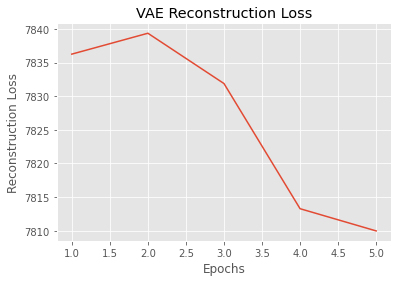

In [127]:
plt.style.use('ggplot')
plt.plot( range(1,len(history.history['loss'])+1), history.history["reconstruction_loss"] )
plt.ylabel("Reconstruction Loss")
plt.xlabel("Epochs")
plt.title('VAE Reconstruction Loss')

images/img_1230.png


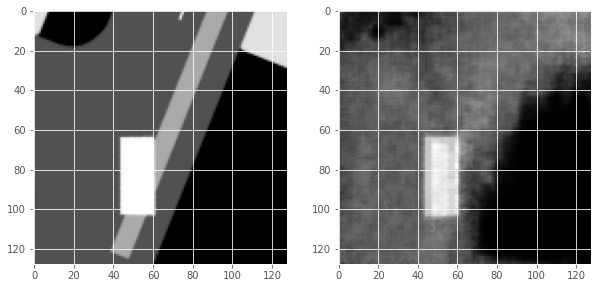

In [175]:
image = f'../images/images/'+np.random.choice(to_test)
fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=2)

def getOut(path):
    inp = read_transform(path).reshape(1, 128, 128, 1)
    emb = encoder.predict(inp)[0]
    out = decoder.predict(emb)
    return out[0]

img = read_transform(image)
ax[0].imshow(img, cmap="gray")
ax[1].imshow(getOut(image), cmap="gray")
print(image)

In [167]:
encoder.save('vae_encoder.h5')
decoder.save('vae_decoder.h5')